# Bernstein–Vazirani algorithm #

d:\anaconda3\envs\Qiskit_Test_46\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


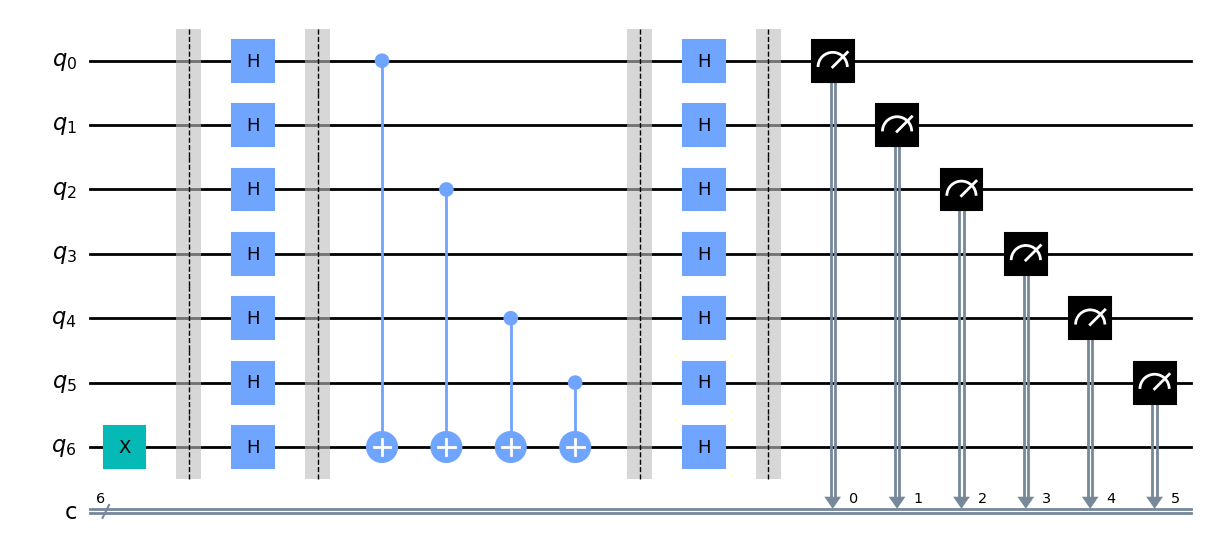

In [1]:
from qiskit import *
s = '110101'
n = len(s)
qc = QuantumCircuit(n+1,n)
# Step 0
qc.x(n) # the n+1 qubits are indexed 0...n, so the last qubit is index n
qc.barrier() # just a visual aid for now
# Step 1
qc.h(range(n+1)) # range(n+1) returns [0,1,2,...,n] in Python. This covers all the qubits
qc.barrier() # just a visual aid for now
# Step 2
for ii, yesno in enumerate(reversed(s)):
    if yesno == '1': 
        qc.cx(ii, n)
qc.barrier() # just a visual aid for now
# Step 3
qc.h(range(n+1)) # range(n+1) returns [0,1,2,...,n] in Python. This covers all the qubits
qc.barrier() # just a visual aid for now
qc.measure(range(n), range(n)) # measure the qubits indexed from 0 to n-1 and store them into the classical bits indexed 0 to n-1
qc.draw(output='mpl')

# Simulation result #

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19888\1457962226.py:4: DeprecationWarning: The class ``qiskit.providers.fake_provider.fake_backend.FakeBackendV2`` is deprecated as of qiskit 0.46.0. It will be removed in qiskit 1.0. All fake backend instances based on real device snapshots (`FakeVigo`,`FakeSherbrooke`,...) have been migrated to the `qiskit_ibm_runtime` package. To migrate your code, run `pip install qiskit-ibm-runtime` and use `from qiskit_ibm_runtime.fake_provider import FakeExample` instead of `from qiskit.providers.fake_provider import FakeExample`. 
  simulator=FakeCasablancaV2()
d:\anaconda3\envs\Qiskit_Test_46\lib\site-packages\qiskit\providers\fake_provider\fake_backend.py:366: RuntimeWarning: Aer not found using BasicProvider and no noise
  warnings.warn("Aer not found using BasicProvider and no noise", RuntimeWarning)


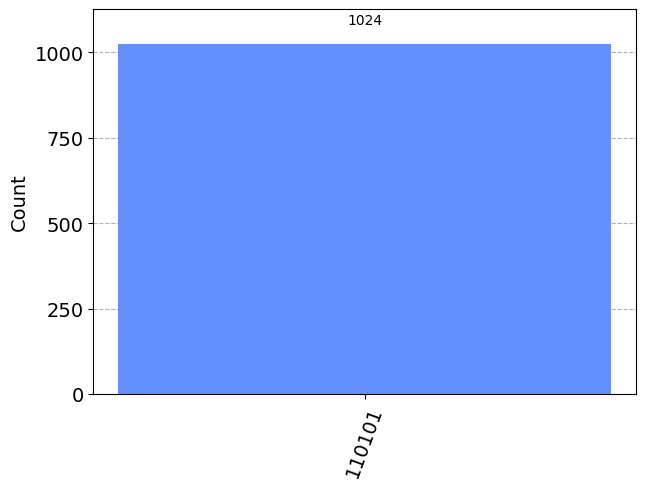

In [2]:
from qiskit.visualization import *
from qiskit.providers.fake_provider import FakeCasablancaV2

simulator=FakeCasablancaV2()
qc = transpile(qc, simulator)
sim_result = simulator.run(qc).result()
plot_histogram(sim_result.get_counts())

# QuantumCircuit to pulse-level circuit #
Qiskit versions higher than 1.0.0 do not support qiskit.schedule and I didn't find another method. Therefore, this work is implemented by qiskit 0.46.2

Schedule((0, Play(Drag(duration=160, sigma=40, beta=0.4811689629930638, amp=0.1774189840105327, angle=0.0, name='drag_d8bd'), DriveChannel(5), name='drag_d8bd')), (160, ShiftPhase(-1.5707963268, DriveChannel(0))), (160, ShiftPhase(-1.5707963268, DriveChannel(1))), (160, ShiftPhase(-1.5707963268, DriveChannel(2))), (160, ShiftPhase(-1.5707963268, DriveChannel(3))), (160, ShiftPhase(-1.5707963268, DriveChannel(4))), (160, ShiftPhase(-1.5707963268, DriveChannel(5))), (160, ShiftPhase(-1.5707963268, DriveChannel(6))), (160, ShiftPhase(-1.5707963268, ControlChannel(0))), (160, ShiftPhase(-1.5707963268, ControlChannel(1))), (160, ShiftPhase(-1.5707963268, ControlChannel(10))), (160, ShiftPhase(-1.5707963268, ControlChannel(11))), (160, ShiftPhase(-1.5707963268, ControlChannel(2))), (160, ShiftPhase(-1.5707963268, ControlChannel(3))), (160, ShiftPhase(-1.5707963268, ControlChannel(4))), (160, ShiftPhase(-1.5707963268, ControlChannel(5))), (160, ShiftPhase(-1.5707963268, ControlChannel(6))), (

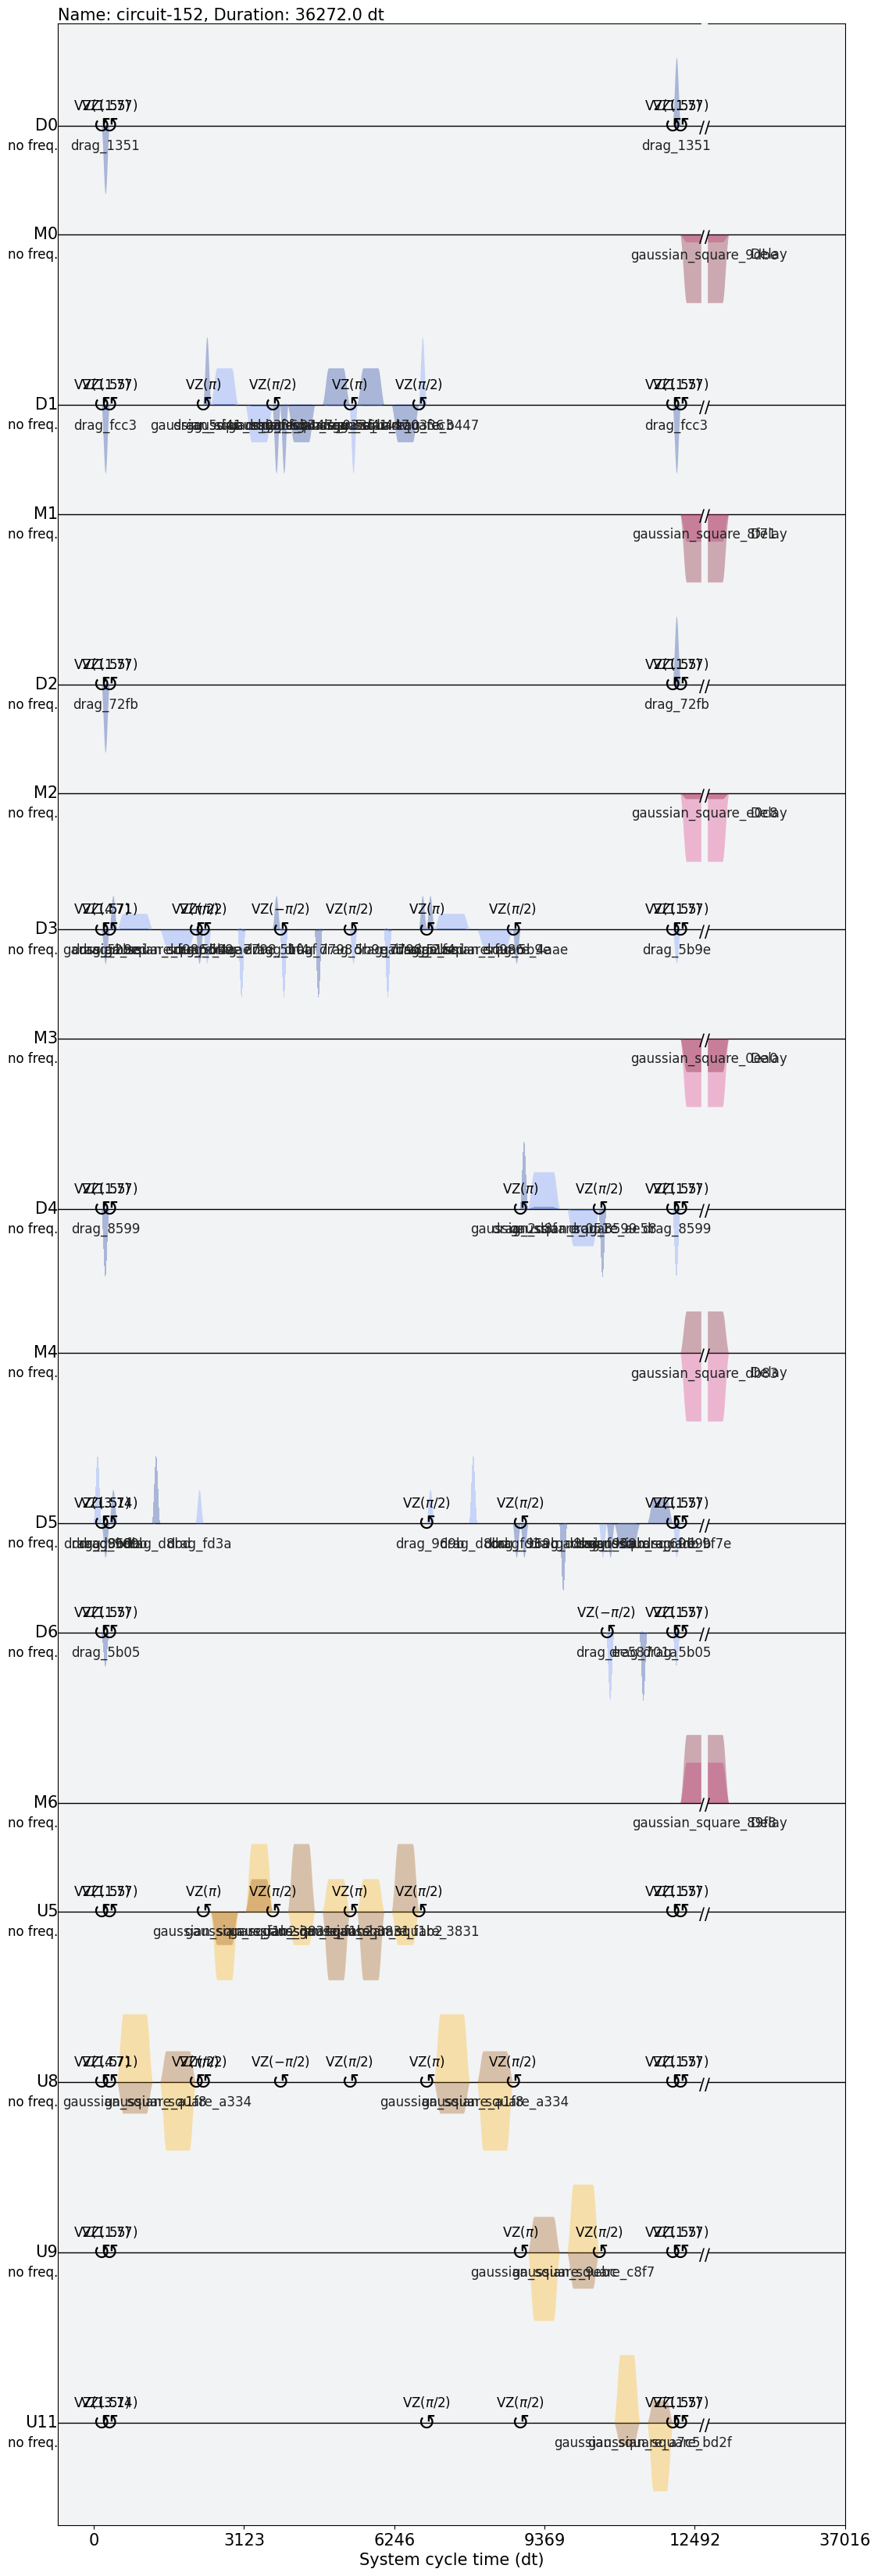

In [3]:
sched = schedule(qc, simulator)
print(sched)
sched.draw()

# Power Trace #

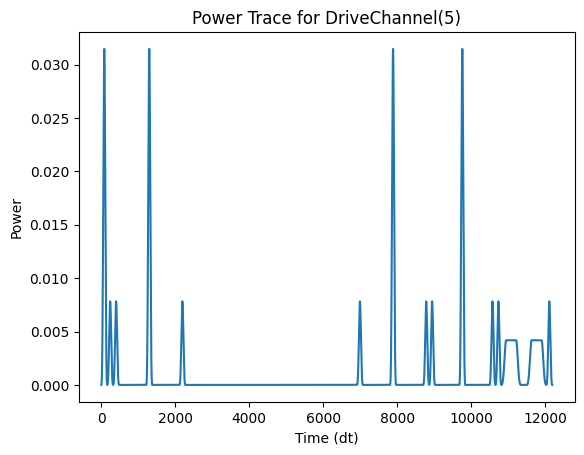

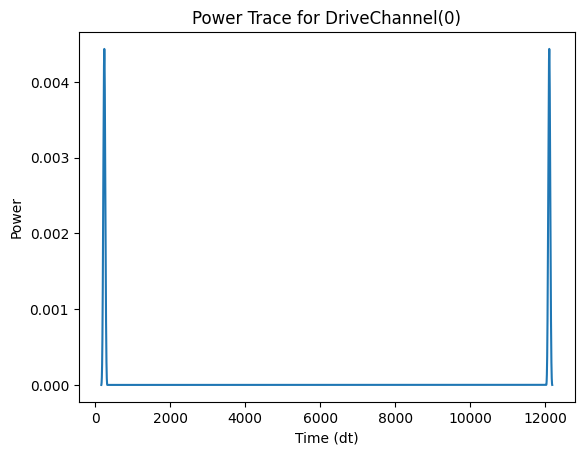

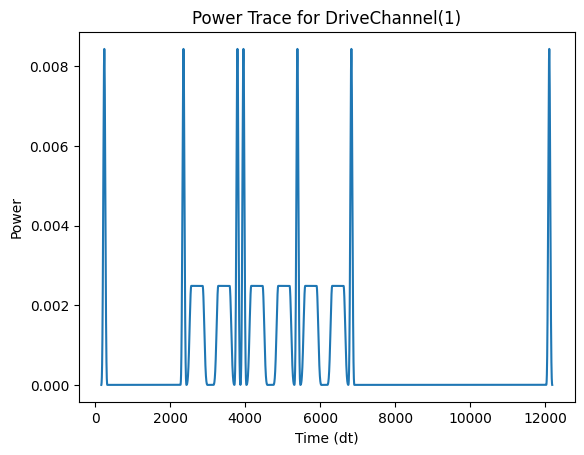

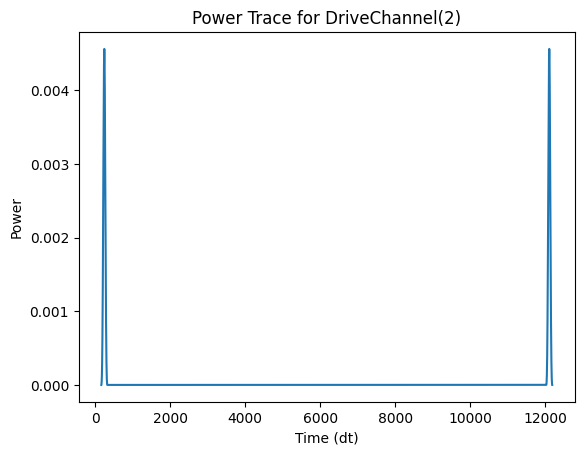

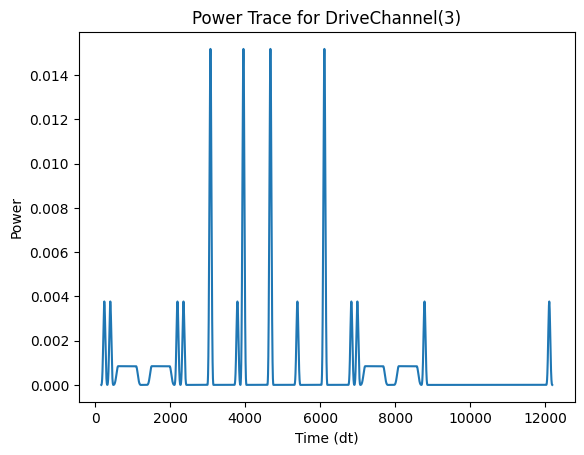

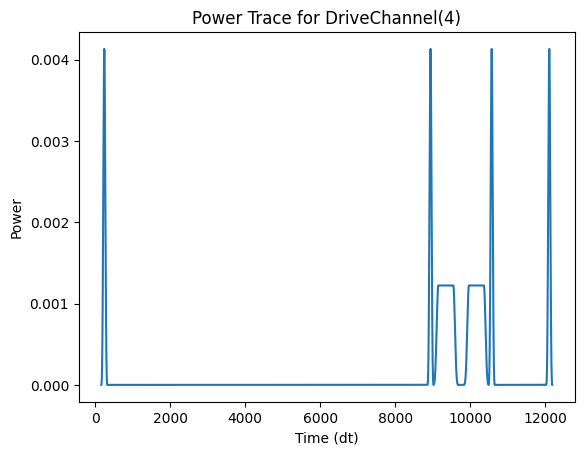

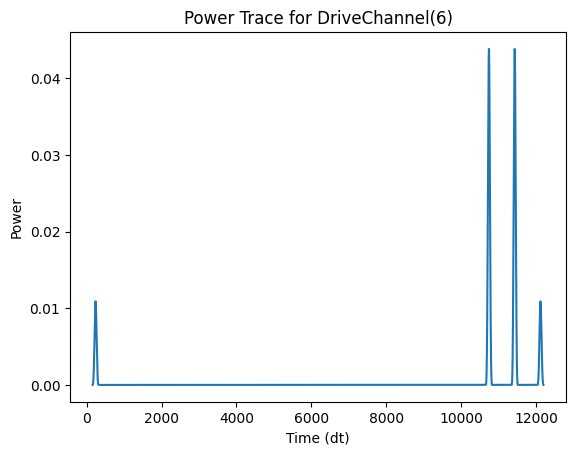

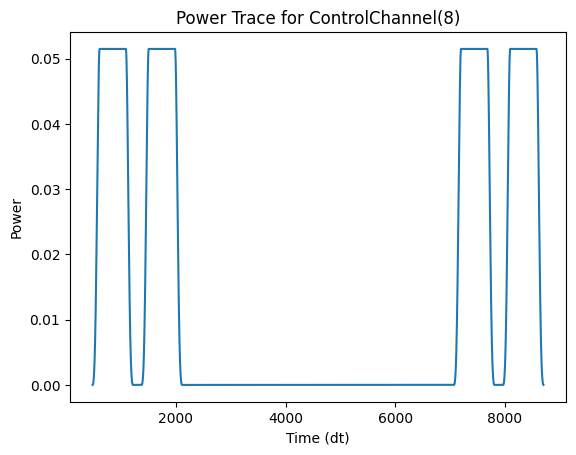

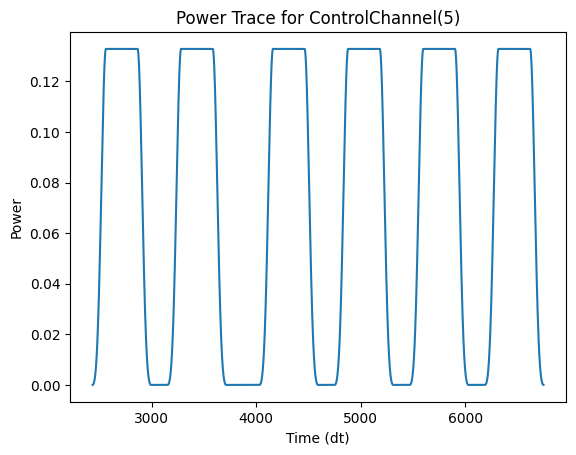

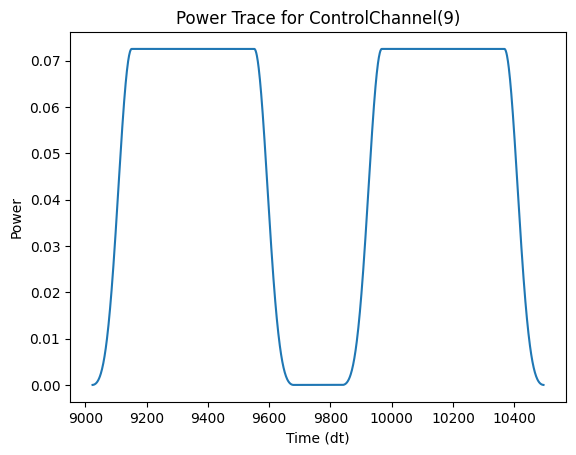

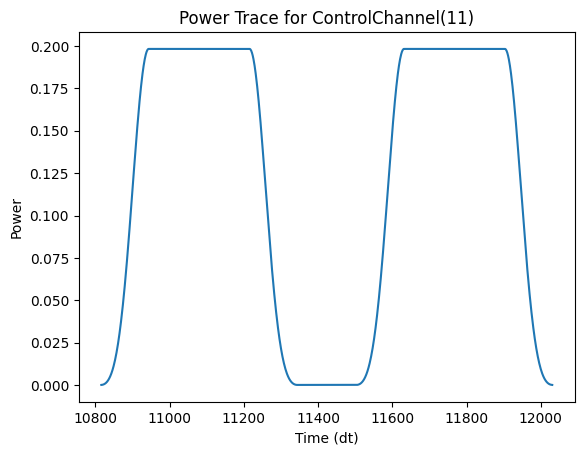

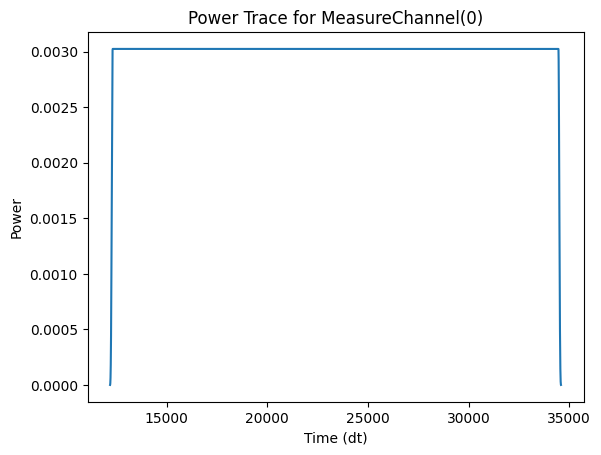

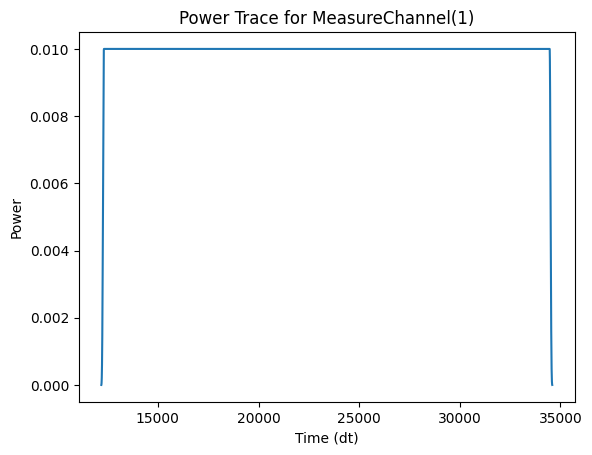

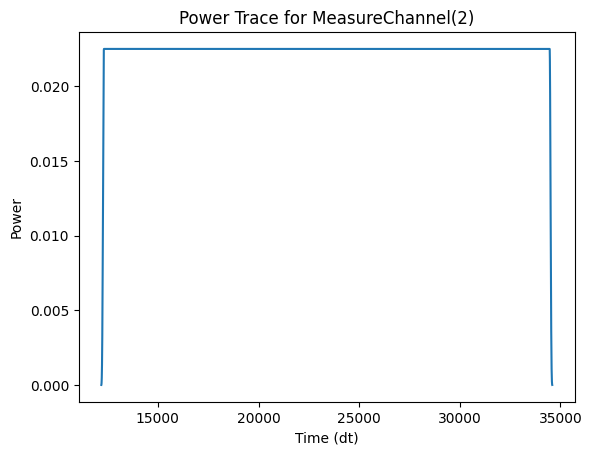

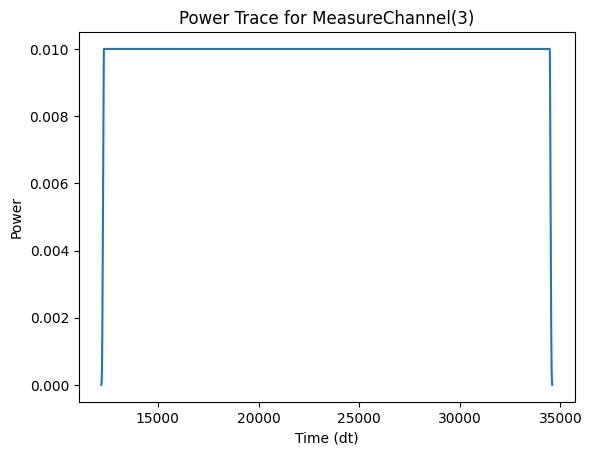

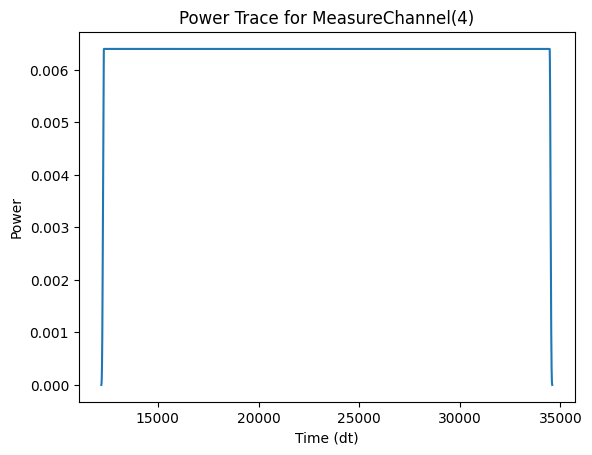

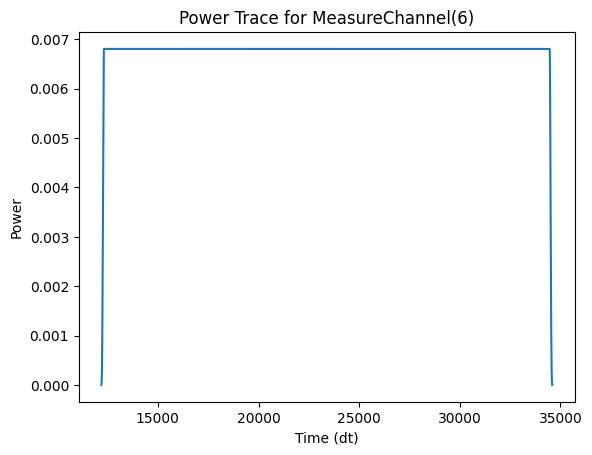

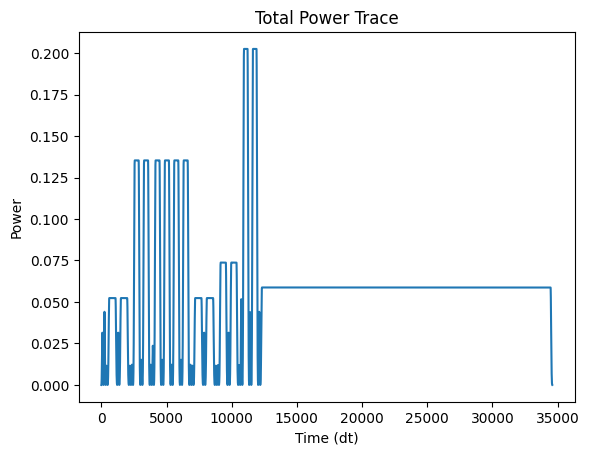

In [6]:
from qiskit import pulse
import numpy as np
import matplotlib.pyplot as plt
time_series = {}
total_power_trace = {}
for time, instruction in sched.instructions:
    if isinstance(instruction, pulse.Play):
        pulse_waveform = instruction.pulse
        channel = instruction.channel
        if isinstance(pulse_waveform, pulse.library.ScalableSymbolicPulse):
            amplitude = pulse_waveform.get_waveform().samples
        else:
            amplitude = pulse_waveform.samples
        power = np.real(amplitude)**2 + np.imag(amplitude)**2
        start_time = time
        times = np.arange(start_time, start_time + len(power))
        if channel not in time_series:
            time_series[channel] = (times, power)
        else:
            existing_times, existing_power = time_series[channel]
            time_series[channel] = (np.concatenate([existing_times, times]), 
                                    np.concatenate([existing_power, power]))

        for t, p in zip(times, power):
            if t in total_power_trace:
                total_power_trace[t] += p
            else:
                total_power_trace[t] = p    
        
for channel, (times, power) in time_series.items():
    plt.figure()
    plt.plot(times, power)
    plt.title(f'Power Trace for {channel}')
    plt.xlabel('Time (dt)')
    plt.ylabel('Power')
    plt.show()

total_times = np.array(sorted(total_power_trace.keys()))
total_power = np.array([total_power_trace[t] for t in total_times])

time_intervals = np.diff(total_times, prepend=total_times[0])
total_energy = np.sum(total_power * time_intervals)

print(total_energy)
print()

plt.figure()
plt.plot(total_times, total_power)
plt.title('Total Power Trace')
plt.xlabel('Time (dt)')
plt.ylabel('Power')
plt.show()